In [51]:
import cv2, time, os, numpy as np
import time
from matplotlib import pyplot as plt

np.random.seed(123)
# https://github.com/opencv/opencv/wiki/TensorFlow-Object-Detection-API
classFile ="../coco.names" 
threshold = 0.5

perf = []


In [52]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [53]:
def readClasses( classesFilePath,is_yolo=False): 
    global classesList
    global colorList
    global classAllowed
    classAllowed=[0,1,2,3,5,6,7]
    
    with open(classesFilePath, 'r') as f:
        classesList = f.read().splitlines()
        
    #   delete all class except person and vehiccule 
    classesList=classesList[0:8]
    classesList.pop(4)
    print(classesList)
    
    if is_yolo==False:
        classesList.insert(0,-1)
    # Colors list 
    colorList = np.random.uniform(low=0, high=255, size=(len(classesList), 3))

In [54]:
def init_model_yolo(modelName_="yolov4"):
    global model
    global classFile
    global configPath
    global modelPath
    global modelName
    modelName=modelName_
    
    configPath=os.path.join("../opencv_model",modelName,modelName+".cfg")
    modelPath=os.path.join("../opencv_model",modelName,modelName+".weights")
    
    net = cv2.dnn.readNet(modelPath,configPath)
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA_FP16)

    model=cv2.dnn_DetectionModel(net)
    model.setInputParams(size=(416, 416), scale=1/255, swapRB=True)

    readClasses(classFile,is_yolo=True)
     

In [55]:
def init_model_opencv(modelName_="ssd_mobilenet_v3_large_coco_2020_01_14"):
    global model
    global classFile
    global configPath
    global modelPath
    global modelName
    modelName=modelName_
    
    configPath=os.path.join("../opencv_model",modelName,modelName+".pbtxt")
    modelPath=os.path.join("../opencv_model",modelName,"frozen_inference_graph.pb")
    model=cv2.dnn_DetectionModel(modelPath,configPath)

    model.setInputSize(320,320)
    model.setInputScale(1.0/127.5)
    model.setInputMean((127.5,127.5,127.5))
    model.setInputSwapRB(True)
    readClasses(classFile)
    

In [38]:
def init_model_tensorflow(modelName_="ssd_mobilenet_v3_large_coco_2020_01_14"):
   
    readClasses(classFile)
    

In [56]:
def imageDetection( image, threshold = 0.5,videoFrame=False,imagePath=None): 
    global model
    global modelName
    global perf

    s = time.time()
    classLabelIDs,confidences,bboxs= model.detect(image,confThreshold=threshold)
    curr_time = (time.time()-s )*1000
    if videoFrame==False :
        print(modelName )
        print("execution time : ",str(curr_time))  
        
    bboxs=list(bboxs)
    confidences=list(np.array(confidences).reshape(1,-1)[0])
    confidences=list(map(float,confidences))

    bboxIdx=cv2.dnn.NMSBoxes(bboxs,confidences,score_threshold=0.4,nms_threshold=0.2)

    if imagePath != None:
        imagePerf={"imagePath":imagePath,"exec_time":curr_time,"modelName":modelName,"object_detected":len(bboxIdx)}
        perf.append(imagePerf)
        
    if len(bboxIdx) !=0 :
        for i in range (0,len(bboxIdx)):
            
            bbox=bboxs[np.squeeze(bboxIdx[i])]
            classConfidence = confidences[np.squeeze(bboxIdx[i])]
            classLabelID=np.squeeze(classLabelIDs[np.squeeze(bboxIdx[i])])
    
            if (classLabelID in classAllowed)==False:
                continue

            classLabel=classesList[classAllowed.index(classLabelID)]
            classColor = colorList[classAllowed.index(classLabelID)]
            displayText = '{}: {:.2f}'.format(classLabel, classConfidence) 
            if videoFrame==False:
                print(displayText)
            x,y,w,h=bbox
            cv2.rectangle(image,(x,y),(x+w,y+h),color=classColor,thickness=2)
            cv2.putText(image, displayText, (x, y - 10), cv2.FONT_HERSHEY_PLAIN, 1, classColor, 2)

        return image
        
    return image

In [57]:
def predictImage( imagePath, threshold = 0.5): 
    global modelName
    image = cv2.imread(imagePath)
#     imagePerf={"a":"b"}
# #     perf[imagePath]=imagePerf
    bboxImage = imageDetection(image, threshold,imagePath=imagePath)
    pathnew="../"+modelName + "_" + imagePath[-5:-4] + ".jpg"
    cv2.imwrite(pathnew, bboxImage) 
  
    img = cv2.cvtColor(bboxImage, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    
    print(modelName + "_" + imagePath[-5:-4]+".jpg")
    cv2.imshow("Result", bboxImage)
    cv2.waitKey(0)
    cv2.destroyAllWindows() 
    
#     global classesList
# print(classesList)

In [58]:
def predictVideo( videoPath, threshold = 0.5): 
    print(modelName )
    print("videoPath : ",str(videoPath))
        
    cap=cv2.VideoCapture(videoPath)
    if ( cap.isOpened()==False):
        print("ERROR opening file ..")
        return
    (success,image)=cap.read()
    startTime=0
    
    while success:
        currentTime=time.time()
        fps=1/(currentTime-startTime)
        startTime=currentTime
        bboxImage= imageDetection(image, threshold,videoFrame=True)
        cv2.putText(bboxImage,"FPS : "+str(int(fps)),(20,70),cv2.FONT_HERSHEY_PLAIN,2,(0,255,0),2)
        cv2.imshow("Result",bboxImage)
        
        key=cv2.waitKey(1) & 0xFF
        if key==ord("q"):
            break
            
        (success,image)=cap.read()
    cv2.destroyAllWindows()

#  init detection model

In [59]:
# modelName="ssd_mobilenet_v3_large_coco_2020_01_14"
init_model_opencv(modelName_="ssd_mobilenet_v3_large_coco_2020_01_14")

['person', 'bicycle', 'car', 'motorcycle', 'bus', 'train', 'truck']


In [60]:
# yolov7-tiny
# yolov4-tiny
# yolov4-csp
# yolov4
# yolov3
# yolov3-tiny
# yolov2
init_model_yolo(modelName_="yolov3")

['person', 'bicycle', 'car', 'motorcycle', 'bus', 'train', 'truck']


In [62]:
readClasses(classFile)

['person', 'bicycle', 'car', 'motorcycle', 'bus', 'train', 'truck']


# TEST FUNCTIONs

yolov3
execution time :  807.0166110992432
bicycle: 0.99
bicycle: 0.99
bicycle: 0.99
bicycle: 0.98
bicycle: 0.97
bicycle: 0.97
bicycle: 0.97
bicycle: 0.97
bicycle: 0.97
bicycle: 0.97
bicycle: 0.96
bicycle: 0.95
bicycle: 0.94
bicycle: 0.93
bicycle: 0.90
bicycle: 0.83
bicycle: 0.81
bicycle: 0.81
bicycle: 0.78
bicycle: 0.72
bicycle: 0.62
bicycle: 0.61
bicycle: 0.54
bicycle: 0.47
bicycle: 0.46
bicycle: 0.45
bicycle: 0.45


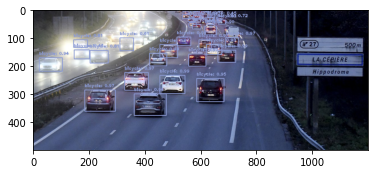

yolov3_1.jpg


In [63]:
imagePath = "../test/1.jpg"
predictImage( imagePath,threshold=0.4)

yolov3
execution time :  616.9736385345459
person: 1.00
person: 0.99
person: 0.97
person: 0.97


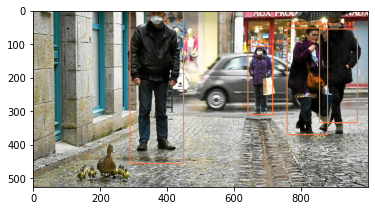

yolov3_0.jpg


In [47]:
imagePath = "../test/0.jpg" 
predictImage( imagePath,threshold=0.5)

yolov3
execution time :  535.4511737823486
car: 0.98
car: 0.97
car: 0.94
car: 0.94
car: 0.89


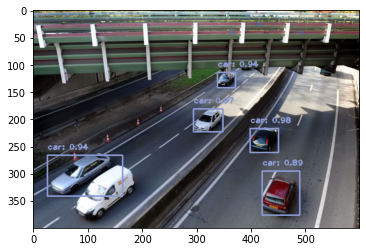

yolov3_4.jpg


In [48]:
imagePath = "../test/4.jpg" 
predictImage( imagePath,threshold=0.5)

In [49]:
videoPath="test/2.mp4"
predictVideo(videoPath, threshold=0.4)

yolov3
videoPath :  test/2.mp4
ERROR opening file ..


In [212]:
perf

[{'imagePath': 'test/1.jpg',
  'exec_time': 1091.8798446655273,
  'modelName': 'yolov3',
  'object_detected': 27},
 {'imagePath': 'test/1.jpg',
  'exec_time': 862.34450340271,
  'modelName': 'yolov3',
  'object_detected': 27},
 {'imagePath': 'test/1.jpg',
  'exec_time': 452.8076648712158,
  'modelName': 'yolov3',
  'object_detected': 27},
 {'imagePath': 'test/0.jpg',
  'exec_time': 425.900936126709,
  'modelName': 'yolov3',
  'object_detected': 6},
 {'imagePath': 'test/2.jpg',
  'exec_time': 425.8120059967041,
  'modelName': 'yolov3',
  'object_detected': 17}]